# MNIST Digit Recognizer

**Authors: Clement, Calvin, Tilova**

---

Welcome to the very first project of the **Tequila Chicas**! We will be classifying images of hand written numbers to their corresponding digits. This project follows the guidelines and uses the data set provide from the Kaggle Competition [here](https://www.kaggle.com/competitions/digit-recognizer/overview). 

## Introduction  

**MARKDOWN**

<a id = 'toc'></a>
    
## Table of Contents
---
1. [Convolutional Neural Network](#CNN)

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ignores the filter warnings
import warnings
warnings.filterwarnings('ignore')

<a id = 'CNN'></a>
### 1. Convolutional Neural Network
---
Loading the test and train set CSVs files.

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

We need to set our independent (X) and dependent (y) variables as `numpy arrays` from the dataset.

In [3]:
X = df_train.iloc[:, 1:].to_numpy()
y = df_train.iloc[:, 0].to_numpy()

# sanity check
print(X.shape, y.shape)

(42000, 784) (42000,)


We will perform a **train_test_split()** to split our dataset into train and validation sets.
- Validation size of 25% of the data.
- Stratify=y to make sure distribution of the classes remain the same in both training and validation set.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, y_train.shape

((31500, 784), (31500,))

#### 1.1 Image Preprocessing

---

**Steps**
1. Scale the data
2. Reshape the 1-D array into 2-D
2. Convert 2-D array into Torch tensors

In [5]:
# instantiate standard scaler
ss = StandardScaler()

# fit and transform training
X_train = ss.fit_transform(X_train)

# ONLY transform X_val
X_val = ss.transform(X_val)

In [6]:
# reshape training & validation
X_train = np.array(X_train).reshape(-1, 28, 28)
X_val = np.array(X_val).reshape(-1, 28, 28)

# sanity check
print(X_train.shape, X_val.shape)

(31500, 28, 28) (10500, 28, 28)


In [7]:
### To torch tensors ###
# Independent Variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Dependent Variable
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Sanity Check
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([31500, 28, 28]) torch.Size([31500]) torch.Size([10500, 28, 28]) torch.Size([10500])


In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Define the max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the fully connected (linear) layers
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # Adjust the input size based on the image dimensions
        self.fc2 = nn.Linear(128, 10)  # Output size is 10 for 10 classes (e.g., digits 0-9)
        
        # Define activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply first convolutional layer followed by ReLU activation and max pooling
        x = self.pool(self.relu(self.conv1(x)))
        
        # Apply second convolutional layer followed by ReLU activation and max pooling
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 14 * 14)  # Adjust the size based on the output size of the convolutional layers
        
        # Apply fully connected layers followed by ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
model = SimpleCNN()


### 1.2 Convolution Layering Explained

Convolutional Neural Networks utilizes the idea of convolution to extract key features in objects such as images. For images, a kernel or window is slid through the image in order to extract key features. More specifically, if we have a 28x28 pixel image with 1 colour channel (greyscale), a convolution window can have a dimension of, let's say 3x3, and is slid across the one image channel where in each position the dot product is computed to extract key features. Depending on whether or not padding is added, we will end up with an output feature map that may or may not have the same dimension as the input image, 28x28. 
> **Note 1**: The convolution we are using is 2D, i.e. a square, meaning it is applied per channel. Each (colour) channel has a convolution window. For greyscale images, we only have 1 convolution window, but for RGB images each colour channel has a separate window. 
> **Note 2**: 1x28x28 is known as the **input feature** for the convolution layers

For colour images, let's say RGB, instead of 1 channel we have 3 now meaning our input features becomes 3x28x28 
...

   
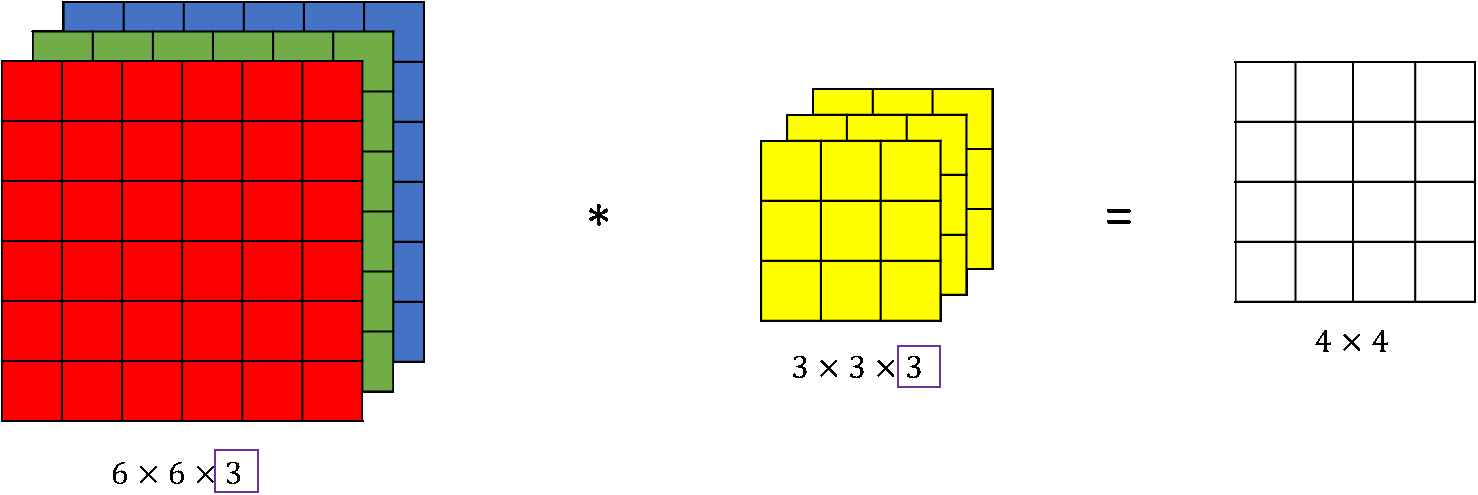

In [87]:
class MultilayerCNN(nn.Module):
    """Basic multi-layer CNN architecture."""

    def __init__(self):
        """Define the main components of the network including the loss and optimizer."""
        super(MultilayerCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Convolutional block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ) # the size of the flattened output tensor will be 64*128 // (2*2)


        self.fc_layer = nn.Sequential(
        nn.Linear(in_features= 128*3*3, out_features=512),  # Corrected input size
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512, out_features=10)  # Assuming 10 output classes
        )

        self.softmax_layer = nn.Softmax(dim=1)

        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=.001, momentum=0.9)

    def forward(self, x):
        """Perform forward pass."""
        # pass through the convolutional layers
        x = self.conv_layer(x)

        # flatten the output of the convolution
        x = x.view(x.size(0), -1)

        # pass through the fully connected layers
        x = self.fc_layer(x)

        if not self.training:
            x = self.softmax_layer(x)

        return x

    def predict(self, x):
        '''
        Get hard class predictions from the
        feature data
        '''
        predictions = self.forward(x)

        # Find highest class logit, notice we don't need to convert to
        # probabilities to do hard predictions, we can simply choose the
        # highest values
        hard_class_predictions = torch.argmax(predictions, dim=1)

        return hard_class_predictions

In [88]:
# initialize the model
CNN_model = MultilayerCNN()
#CNN_model = SimpleCNN()
CNN_model

MultilayerCNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (softmax_layer): Softmax(dim=1)
  (cross_entropy_loss): CrossEntropyLoss()
)

In [89]:
# take the first training example
sample = X_train[0]
sample_label = y_train[0]

In [90]:
sample.unsqueeze(0).unsqueeze(1).shape

torch.Size([1, 1, 28, 28])

In [97]:
# pass it through the model
outputs = CNN_model(sample.unsqueeze(0).unsqueeze(1))

In [98]:
# find the loss
CNN_model.cross_entropy_loss(outputs, torch.tensor([sample_label]))

tensor(2.3752, grad_fn=<NllLossBackward>)

In [93]:
64*128 // (2*2)

2048

In [94]:
X_train.shape

torch.Size([31500, 28, 28])

In [95]:
sample.shape

torch.Size([28, 28])